## Initialization

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [10]:
# Define the base path to your dataset
base_dir = '/datasets/faces/'

# Paths to labels and images
labels_path = os.path.join(base_dir, 'labels.csv')
images_dir = os.path.join(base_dir, 'final_files/')

# Load labels
labels = pd.read_csv(labels_path)


## EDA

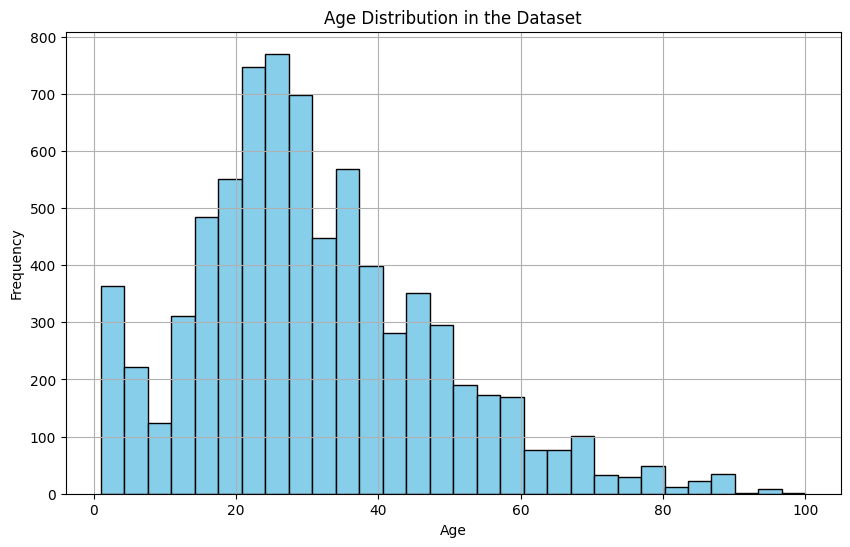

In [11]:
# Plot a histogram of age distribution
plt.figure(figsize=(10, 6))
plt.hist(labels['real_age'], bins=30, color='skyblue', edgecolor='black')
plt.title('Age Distribution in the Dataset')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

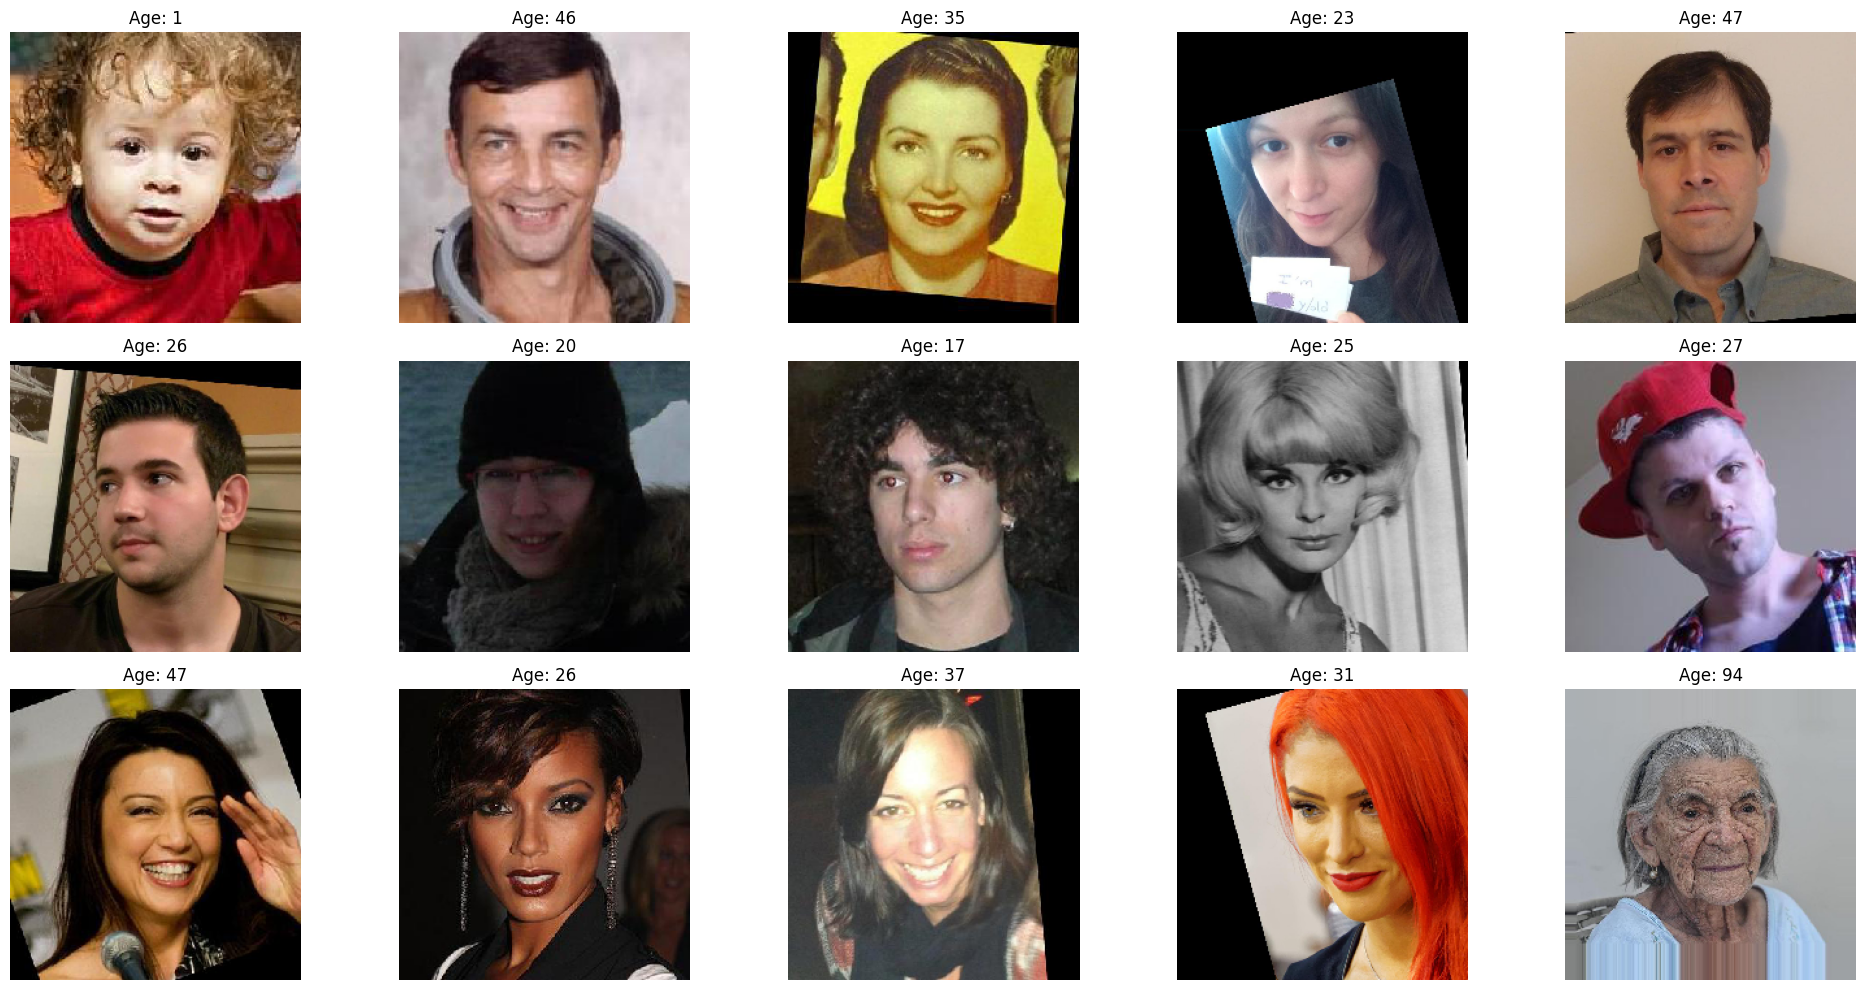

In [12]:
# Function to plot images
def plot_images_for_ages(labels, images_dir, num_images=15):
    """
    Plots a sample of images for different ages.
    
    Parameters:
        labels (pd.DataFrame): DataFrame containing image file names and corresponding ages.
        images_dir (str): Directory where images are stored.
        num_images (int): Number of images to display.
    """
    # Select a random sample of images
    sample = labels.sample(num_images, random_state=42)
    
    # Set up the plot
    plt.figure(figsize=(20, 10))
    
    for i, (index, row) in enumerate(sample.iterrows()):
        file_name = row['file_name']
        age = row['real_age']
        img_path = os.path.join(images_dir, file_name)
        
        # Load and plot the image
        img = load_img(img_path, target_size=(224, 224))
        img = img_to_array(img) / 255.0
        
        plt.subplot(3, 5, i+1)  # Adjust the layout (3 rows, 5 columns)
        plt.imshow(img)
        plt.title(f'Age: {age}', fontsize=12)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot a sample of images
plot_images_for_ages(labels, images_dir, num_images=15)

### Findings

Age Distribution Analysis:

We have two columns, the file names and the targets, and about 7500 total images. The ages range from 1 year old to 100 years old, centered at 29 with a slightly right-skewed distribution. Most of the ages look to bve between 10 and 40, which is approximately the age range where it may not be obvious if someone is aged 21.
Although this is a regression problem, the key problem is to distinguish between those aged under 21 or 21 and older. There are about 2.5 times as many samples for adults as there are for young adults and children, but this is fair given that ages from 1 to 100 are represented.

Image analysis:

The pictures are of varying dimensions, orientation, and location. Many are off-center and have inconsistently shaped and sized black borders. The rest of the images likely continue in this style. However, most of the faces, even ones in rotated images, are essentially right-side-up.
I will most likely need to augment the images to yield better performance.

Horizontal flips would work on human faces in general, as mirrored versions of faces are very plausable. Vertical flips would be nonsensical.

Many of the images are somewhat rotated. Fortunately, some corrections appear to have been made by the dataset creator, as the faces themselves tend to be mostly un-rotated. I will rotate the images randomly between -30 and 30 degrees to add some variation, in case some customers' faces have a tilt.

The borders present also pose a question. It may be possible to process these images and remove the black borders, but that could end up altering some of the images more than desired. I'll shift the images horizontally and vertically to account for instances where the face is not perfectly centered.

Some of the faces are closer to the camera lens than others. I'll zoom in to 20% magnification to account for faces of different proximities to the lens.

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [13]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [14]:
def load_train(path):
    """
    It loads the train part of dataset from path
    """

    train_datagen = ImageDataGenerator(
        validation_split=0.2,
        rescale=1 / 255.0,
        horizontal_flip=True,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rotation_range=0.2,
        zoom_range=0.2,
    )

    #     The flow_from_dataframe method attaches the targets to their respective images, taking
    # the labels into dataframe, file names into x_col, the target variable into y_col, and the image
    # directory into directory.
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv("/datasets/faces/labels.csv"),
        directory="/datasets/faces/final_files/",
        x_col="file_name",
        y_col="real_age",
        target_size=(224, 224),
        batch_size=16,
        class_mode="raw",
        subset="training",
        seed=0,
    )

    return train_datagen_flow

In [15]:
def load_test(path):
    """
    It loads the validation/test part of dataset from path
    """

    test_datagen = ImageDataGenerator(validation_split=0.2, rescale=1 / 255.0)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv("/datasets/faces/labels.csv"),
        directory="/datasets/faces/final_files/",
        x_col="file_name",
        y_col="real_age",
        target_size=(224, 224),
        batch_size=16,
        class_mode="raw",
        subset="validation",
        seed=0,
    )

    return test_datagen_flow

In [16]:
def create_model(input_shape):
    """
    It defines the model
    """

    backbone = ResNet50(input_shape=input_shape, weights="imagenet", include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(12, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="relu"))
    optimizer = Adam(lr=0.0001)
    model.compile(
        loss="mse",
        optimizer=optimizer,
        metrics=["mae"],
    )

    return model

In [17]:
def train_model(
    model,
    train_data,
    test_data,
    batch_size=None,
    epochs=10,
    steps_per_epoch=None,
    validation_steps=None,
):
    """
    Trains the model given the parameters
    """

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
    )

    return model

### Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [18]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

Test MAE: 6.9393

## Conclusions

# Checklist

- [ ]  Notebook was opened
- [ ]  The code is error free
- [ ]  The cells with code have been arranged by order of execution
- [ ]  The exploratory data analysis has been performed
- [ ]  The results of the exploratory data analysis are presented in the final notebook
- [ ]  The model's MAE score is not higher than 8
- [ ]  The model training code has been copied to the final notebook
- [ ]  The model training output has been copied to the final notebook
- [ ]  The findings have been provided based on the results of the model training

With a mean absolute error of about 7, this model often makes guesses of a person's age that are 7 years off from their real age. The company's goal is to determine a customer's age - under 21, or 21 and over - for the purpose of selling alcohol. The consequences of labeling a young person as an older person, and therefore selling them alcohol, would entail the company committing a crime by selling alcohol to someone underage. Even if the mean absolute error were much lower, for instance 1 year, I would feel uncomfortable recommending this system to the company for their desired use. It would be impossible for even the most advanced computer program to distinguish between someone who is nearly 21 and someone who is actually 21.

We could look at the error distribution and recommend to the company to use the system to identify customers over a certain age, let's say 35, who are practically guaranteed to be over 21. At this point, the clerk could likely do as good a job at age identification, but using a system could standardize the process across all of the company's locations.

It would be hard to glean this from just the data that is provided - the images and ages - but it would be helpful to have information on the race, gender, etc on the people whose images were used in training. Perhaps the MAE is lower than 7 for white people but higher than 7 for people who are not white. The company should understand how the system performs in these slightly different use cases before deploying it and trusting it completely.

They could use these systems at checkout counters to guess the person's age and recommend certain coupons to them based on this prediction, rather than just on the items they purchased. Their purchase data and age prediction could be combined for a better coupon recommendation. The coupons encourage repeat business from customers.

They could deploy this system in addition to continuing to check every customer's ID for a year, and collect data on predictions vs real age, as a way to evaluate performance in real life. They could save customers' images alongside their ages (taken from their IDs) and we could retrain the model, to see if there are any performance boosts.

Overall, they could use this age prediction system for strategies with low consequences of error, but there would be too much risk associated with allowing it to make the final decision on a customer's age, when legality is on the line.